<a href="https://colab.research.google.com/github/JuNoe2020/DMC_class_2021/blob/main/Deep_Learning_code_review/%EC%84%B1%EB%8A%A5%ED%83%90%EC%83%89_%EA%BD%83%20%EC%98%81%EC%83%81%20%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 불러오기

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import VGG16

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import BatchNormalization




In [ ]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):

    self.i = 0
    self.x = []
    self.losses = []
    self.val_losses = []
    self.acc = []
    self.val_acc = []

    self.fig = plt.figure()

    self.logs = []


  def on_epoch_end(self, epoch, logs={}):

    self.logs.append(logs)
    self.x.append(self.i)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.acc.append(logs.get('acc'))
    self.val_acc.append(logs.get('val_acc'))
    self.i += 1

    clear_output(wait=True)
    plt.plot(self.x, self.losses, label="loss")
    plt.plot(self.x, self.val_losses, label="val_loss")
    plt.plot(self.x, self.acc, label="acc")
    plt.plot(self.x, self.val_acc, label="val_acc")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])
    print("acc = ", self.acc[-1], ", val_acc = ", self.val_acc[-1])



# VGG16/ 390 X 390/ SGD/ DROP=0.5/ batch=64

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# callbacks
model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)

callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]

In [ ]:
class_weight = {0 : 1/162 , 1: 1/202}

In [ ]:
conv_layers = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(390, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(390, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['acc'])


train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=vgg16.preprocess_input
).flow_from_directory(
      "data/2flowers/train",
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=vgg16.preprocess_input
).flow_from_directory(
      "data/2flowers/test",
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)


model.summary()

# y_ = model.predict(
#       test_data_generator,
#       steps=test_data_generator.samples/64
# )

# custom_labels = list(test_data_generator.class_indices.keys()) # ADDED
# predicted = np.argmax(y_, axis=1)
# print("predicted category index =", predicted[0])
# print("predicted category name =", custom_labels[predicted[0]])

Found 364 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 390)               9784710   
_________________________________________________________________
batch_normalization_2 (Batch (None, 390)               1560      
_________________________________________________________________
dropout_2 (Dropout)          (None, 390)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 390)               152490    
______________________________________

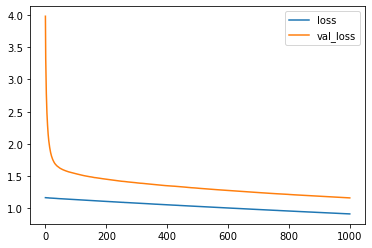

loss =  0.9122504591941833 , val_loss =  1.1608572006225586
3/3 [==============================] - 1s 312ms/step - loss: 1.1609 - acc: 0.9150  
loss= 1.1608572006225586
acc= 0.9150000214576721


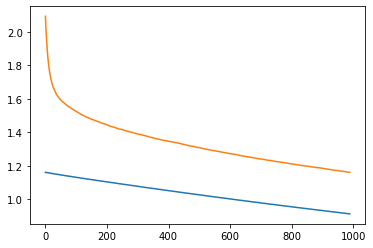

In [ ]:

hist = model.fit(
      train_data_generator,
      validation_data=test_data_generator,
      steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,      
      epochs=1000,
      callbacks = callbacks,
      class_weight = class_weight
)

loss, acc = model.evaluate(
      test_data_generator,
      steps=test_data_generator.samples/64
)
print("loss=", loss)
print("acc=", acc)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()


# VGG16/ 390 X 390/ SGD/ DROP=0.2/ batch=64

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# callbacks
model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)

callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]

In [ ]:
conv_layers = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(390, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(390, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['acc'])


train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=vgg16.preprocess_input
).flow_from_directory(
      "data/2flowers/train",
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=vgg16.preprocess_input
).flow_from_directory(
      "data/2flowers/test",
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)

model.summary()

Found 364 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 390)               9784710   
_________________________________________________________________
batch_normalization_16 (Batc (None, 390)               1560      
_________________________________________________________________
dropout_8 (Dropout)          (None, 390)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 390)               152490    
______________________________________

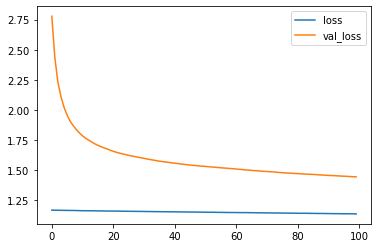

loss =  1.1320569515228271 , val_loss =  1.4408892393112183
3/3 [==============================] - 1s 275ms/step - loss: 1.4409 - acc: 0.8550  


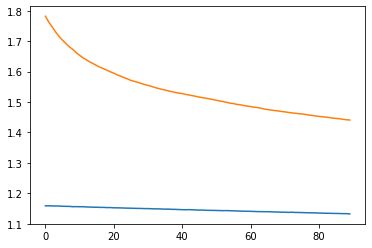

loss= 1.4408891201019287
acc= 0.8550000190734863


In [ ]:
hist = model.fit(
      train_data_generator,
      validation_data=test_data_generator,
      steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,      
      epochs=100,
      callbacks = callbacks,
      class_weight = class_weight
)

loss, acc = model.evaluate(
      test_data_generator,
      steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

# VGG16/ 390 X 390/ SGD/ DROP=0.2/ batch=64/ evaluate_generator

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# callbacks
model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)

callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]

In [ ]:
conv_layers = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(390, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(390, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['acc'])


train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=vgg16.preprocess_input
).flow_from_directory(
      "data/2flowers/train",
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=vgg16.preprocess_input
).flow_from_directory(
      "data/2flowers/test",
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)

model.summary()

Found 364 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_10 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 390)               9784710   
_________________________________________________________________
batch_normalization_40 (Batc (None, 390)               1560      
_________________________________________________________________
dropout_20 (Dropout)         (None, 390)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 390)               152490    
_____________________________________

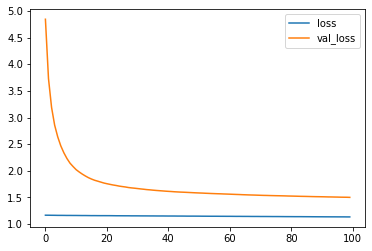

loss =  1.133359670639038 , val_loss =  1.500510573387146


C:\Users\JuNoe\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


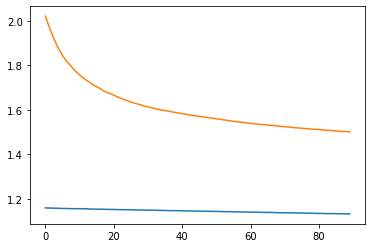

loss= 1.500510573387146
acc= 0.8399999737739563


In [ ]:
hist = model.fit_generator(
      train_data_generator,
      validation_data=test_data_generator,
      steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,      
      epochs=100,
      callbacks = callbacks,
      class_weight = class_weight
)

loss, acc = model.evaluate_generator(
      test_data_generator,
      steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

# VGG16/ 100 X 100/ SGD/ DROP=0.2/ batch=64¶

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# callbacks
model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)

callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]

In [ ]:
conv_layers = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['acc'])


train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=vgg16.preprocess_input
).flow_from_directory(
      "data/2flowers/train",
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=vgg16.preprocess_input
).flow_from_directory(
      "data/2flowers/test",
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)

model.summary()

Found 364 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 100)               2508900   
_________________________________________________________________
batch_normalization_18 (Batc (None, 100)               400       
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               10100     
______________________________________

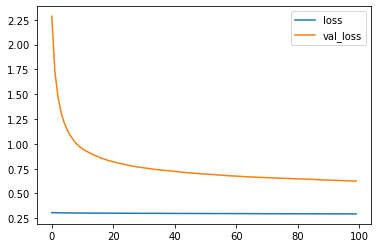

loss =  0.2942759692668915 , val_loss =  0.6248608827590942
3/3 [==============================] - 1s 322ms/step - loss: 0.6249 - acc: 0.8450  


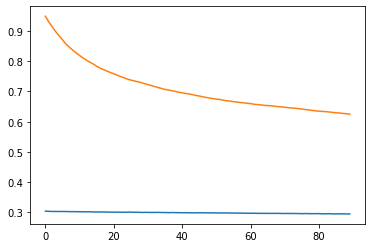

loss= 0.6248608231544495
acc= 0.8450000286102295


In [ ]:
hist = model.fit(
      train_data_generator,
      validation_data=test_data_generator,
      steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,      
      epochs=100,
      callbacks = callbacks,
      class_weight = class_weight
)

loss, acc = model.evaluate(
      test_data_generator,
      steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

# VGG16/ 30 X 30/ SGD/ DROP=0.2/ batch=64

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# callbacks
model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)

callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]

In [ ]:
conv_layers = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(30, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(30, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['acc'])


train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=vgg16.preprocess_input
).flow_from_directory(
      "data/2flowers/train",
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=vgg16.preprocess_input
).flow_from_directory(
      "data/2flowers/test",
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)

model.summary()

Found 364 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 30)                752670    
_________________________________________________________________
batch_normalization_20 (Batc (None, 30)                120       
_________________________________________________________________
dropout_12 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 30)                930       
______________________________________

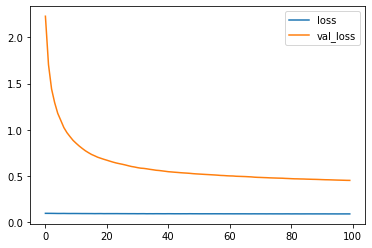

loss =  0.0912928432226181 , val_loss =  0.45355987548828125
3/3 [==============================] - 1s 345ms/step - loss: 0.4536 - acc: 0.8600  


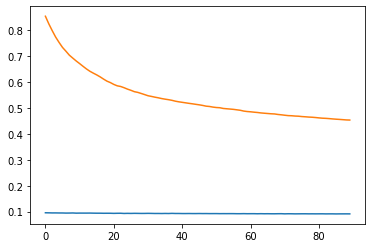

loss= 0.45355990529060364
acc= 0.8600000143051147


In [ ]:
hist = model.fit(
      train_data_generator,
      validation_data=test_data_generator,
      steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,      
      epochs=100,
      callbacks = callbacks,
      class_weight = class_weight
)

loss, acc = model.evaluate(
      test_data_generator,
      steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

# Xception/ 99 X 99/ SGD/ DROP=0.2/ batch=64

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# callbacks
model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, min_lr=0.001)

callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import xception

In [ ]:
# from tensorflow.keras.applications import Xception
# from tensorflow.keras.applications import VGG16

conv_layers = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(99, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(99, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['acc'])


train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=xception.preprocess_input
).flow_from_directory(
      "data/2flowers/train",
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=xception.preprocess_input
).flow_from_directory(
      "data/2flowers/test",
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)
model.summary()


Found 364 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_7 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_21 (Dense)             (None, 99)                9934947   
_________________________________________________________________
batch_normalization_26 (Batc (None, 99)                396       
_________________________________________________________________
dropout_14 (Dropout)         (None, 99)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 99)                9900      
______________________________________

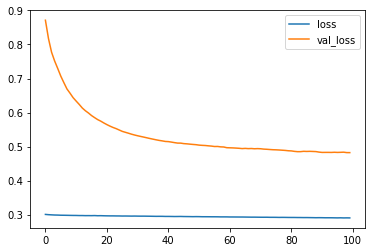

loss =  0.29025834798812866 , val_loss =  0.48214903473854065
3/3 [==============================] - 1s 365ms/step - loss: 0.4821 - acc: 0.9150  
loss= 0.48214903473854065
acc= 0.9150000214576721


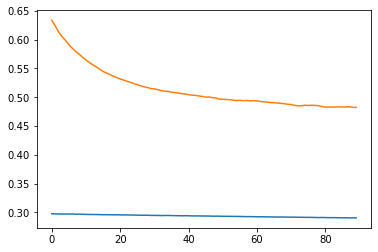

In [ ]:
hist = model.fit(
      train_data_generator,
      validation_data=test_data_generator,
      steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,      
      epochs=100,
      callbacks = callbacks,
      class_weight=class_weight
)


loss, acc = model.evaluate(
      test_data_generator,
      steps=test_data_generator.samples/64
)
print("loss=", loss)
print("acc=", acc)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

# Xception/ 33 X 33/ SGD/ DROP=0.2/ batch=64

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# callbacks
model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, min_lr=0.001)

callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]

In [ ]:
# from tensorflow.keras.applications import Xception
# from tensorflow.keras.applications import VGG16

conv_layers = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(33, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(33, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['acc'])


train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=xception.preprocess_input
).flow_from_directory(
      "data/2flowers/train",
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=xception.preprocess_input
).flow_from_directory(
      "data/2flowers/test",
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)
model.summary()


Found 364 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_8 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_24 (Dense)             (None, 33)                3311649   
_________________________________________________________________
batch_normalization_32 (Batc (None, 33)                132       
_________________________________________________________________
dropout_16 (Dropout)         (None, 33)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 33)                1122      
______________________________________

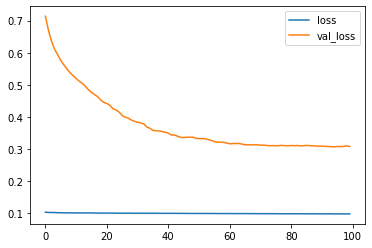

loss =  0.09819546341896057 , val_loss =  0.30809667706489563
3/3 [==============================] - 1s 348ms/step - loss: 0.3081 - acc: 0.9100  
loss= 0.30809667706489563
acc= 0.9100000262260437


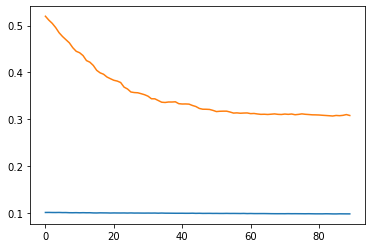

In [ ]:
hist = model.fit(
      train_data_generator,
      validation_data=test_data_generator,
      steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,      
      epochs=100,
      callbacks = callbacks,
      class_weight=class_weight
)


loss, acc = model.evaluate(
      test_data_generator,
      steps=test_data_generator.samples/64
)
print("loss=", loss)
print("acc=", acc)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

# # Xception/ 10 X 10/ SGD/ DROP=0.2/ batch=64

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# callbacks
model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, min_lr=0.001)

callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]

In [ ]:
# from tensorflow.keras.applications import Xception
# from tensorflow.keras.applications import VGG16

conv_layers = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['acc'])


train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=xception.preprocess_input
).flow_from_directory(
      "data/2flowers/train",
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=xception.preprocess_input
).flow_from_directory(
      "data/2flowers/test",
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)
model.summary()


Found 364 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_9 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_27 (Dense)             (None, 10)                1003530   
_________________________________________________________________
batch_normalization_38 (Batc (None, 10)                40        
_________________________________________________________________
dropout_18 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 10)                110       
______________________________________

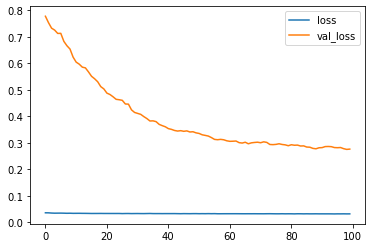

loss =  0.03164469078183174 , val_loss =  0.2761384844779968
3/3 [==============================] - 1s 352ms/step - loss: 0.2761 - acc: 0.8850  
loss= 0.27613845467567444
acc= 0.8849999904632568


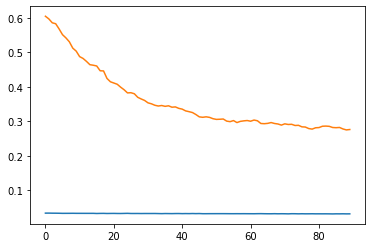

In [ ]:
hist = model.fit(
      train_data_generator,
      validation_data=test_data_generator,
      steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,      
      epochs=100,
      callbacks = callbacks,
      class_weight=class_weight
)


loss, acc = model.evaluate(
      test_data_generator,
      steps=test_data_generator.samples/64
)
print("loss=", loss)
print("acc=", acc)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# callbacks
model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, min_lr=0.001)

callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import xception

In [ ]:
# from tensorflow.keras.applications import Xception
# from tensorflow.keras.applications import VGG16

conv_layers = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(99, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(99, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['acc')


train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=xception.preprocess_input
).flow_from_directory(
      "data/2flowers/train",
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=xception.preprocess_input
).flow_from_directory(
      "data/2flowers/test",
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)
model.summary()


Found 364 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_3 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 99)                9934947   
_________________________________________________________________
batch_normalization_14 (Batc (None, 99)                396       
_________________________________________________________________
dropout_6 (Dropout)          (None, 99)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 99)                9900      
______________________________________

In [ ]:
class_weight = {0 : 1/162 , 1: 1/202}

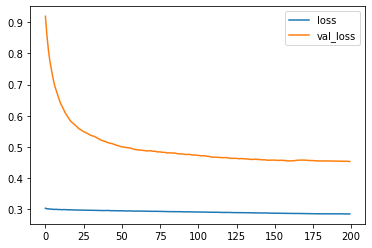

loss =  0.28552350401878357 , val_loss =  0.4535272717475891
3/3 [==============================] - 1s 345ms/step - loss: 0.4535 - acc: 0.9150  
loss= 0.45352721214294434
acc= 0.9150000214576721


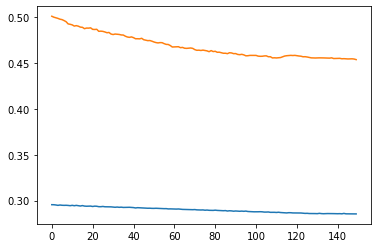

In [ ]:
hist = model.fit(
      train_data_generator,
      validation_data=test_data_generator,
      steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,      
      epochs=200,
      callbacks = callbacks,
      class_weight=class_weight
)


loss, acc = model.evaluate(
      test_data_generator,
      steps=test_data_generator.samples/64
)
print("loss=", loss)
print("acc=", acc)

plt.plot(hist.history['loss'][50:])
plt.plot(hist.history['val_loss'][50:])
plt.show()

# MobileNetV2, adamax

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import mobilenet_v2

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# callbacks
model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, min_lr=0.0001)

callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]

In [ ]:
# from tensorflow.keras.applications import Xception
# from tensorflow.keras.applications import VGG16

conv_layers = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='selu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='selu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adamax', metrics=['acc'])


train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=mobilenet_v2.preprocess_input
).flow_from_directory(
      "data/2flowers/train",
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=mobilenet_v2.preprocess_input
).flow_from_directory(
      "data/2flowers/test",
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)
model.summary()


Found 464 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_13 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_39 (Dense)             (None, 100)               6272100   
_________________________________________________________________
batch_normalization_46 (Batc (None, 100)               400       
_________________________________________________________________
dropout_26 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 100)               10100     
_____________________________________

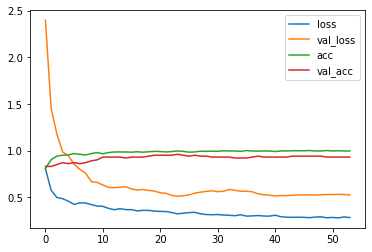

loss =  0.28233960270881653 , val_loss =  0.5252082943916321
acc =  0.9956896305084229 , val_acc =  0.9300000071525574
Epoch 00054: early stopping
1/1 [==============================] - 0s 156ms/step - loss: 0.5252 - acc: 0.9300  
loss= 0.5252082943916321
acc= 0.9300000071525574


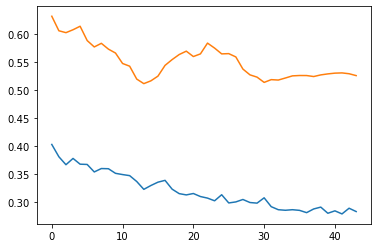

In [ ]:
hist = model.fit(
      train_data_generator,
      validation_data=test_data_generator,
      steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,      
      epochs=100,
      callbacks = callbacks,
#       class_weight=class_weight
)


loss, acc = model.evaluate(
      test_data_generator,
      steps=test_data_generator.samples/64
)
print("loss=", loss)
print("acc=", acc)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

# MobileNetV2, nadam

In [ ]:
# from tensorflow.keras.applications import Xception
# from tensorflow.keras.applications import VGG16

conv_layers = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='LeakyReLU', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='LeakyReLU', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['acc'])


train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=mobilenet_v2.preprocess_input
).flow_from_directory(
      "data/2flowers/train",
      target_size=(224,224),
      batch_size=32,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=mobilenet_v2.preprocess_input
).flow_from_directory(
      "data/2flowers/test",
      target_size=(224,224),
      batch_size=32,
      class_mode='sparse'
)
model.summary()


Found 464 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_29 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_83 (Dense)             (None, 100)               6272100   
_________________________________________________________________
batch_normalization_74 (Batc (None, 100)               400       
_________________________________________________________________
dropout_54 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_84 (Dense)             (None, 100)               10100     
_____________________________________

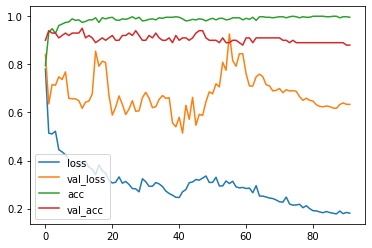

loss =  0.18095631897449493 , val_loss =  0.6334439516067505
acc =  0.9956896305084229 , val_acc =  0.8799999952316284
Epoch 00092: early stopping
3/3 [==============================] - 0s 113ms/step - loss: 0.6334 - acc: 0.8800
loss= 0.6334439516067505
acc= 0.8799999952316284


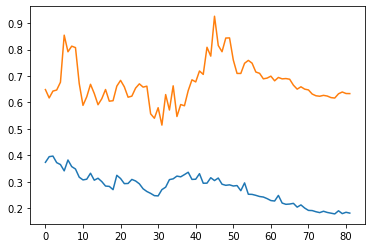

In [ ]:
hist = model.fit(
      train_data_generator,
      validation_data=test_data_generator,
      steps_per_epoch=train_data_generator.samples/32,  
      shuffle=True, 
#       validation_split=0.2,      
      epochs=100,
      callbacks = callbacks,
#       class_weight=class_weight,
#       validation_steps = train_data_generator.samples/64,
      
)


loss, acc = model.evaluate(
      test_data_generator,
      steps=test_data_generator.samples/32
)
print("loss=", loss)
print("acc=", acc)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()